<a href="https://colab.research.google.com/github/susie682/Infosys722--Assignment-4-BDAS/blob/main/3_2_CleaningData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning — Figures 25–33 (Chicago Crime 2017)

This notebook reproduces:
- **Figure 25**: Missing Values by Field (Before Cleaning)
- **Figure 26**: Missing Values by Field (After Cleaning)
- **Figure 27**: Latitude — Before vs. After (boxplots)
- **Figure 28**: Longitude — Before vs. After (boxplots)
- **Figure 29**: Arrest — Raw Encodings (Before)
- **Figure 30**: Arrest — Canonicalized 0/1 (After)
- **Figure 31**: Domestic — Raw Encodings (Before)
- **Figure 32**: Domestic — Canonicalized 0/1 (After)
- **Figure 33**: Case Number — Uniqueness Check

Environment: **Google Colab + PySpark 3.5.1**  
Source CSV: `/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv`


In [1]:
# =============================
# 0) Setup (run in Colab)
# =============================
!pip -q install pyspark==3.5.1

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession, functions as F, types as T
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Cleaning_Figs25to33").getOrCreate()

# Global paths
CSV_DIR = "/content/drive/MyDrive/Infosys 722"
FIG_DIR = f"{CSV_DIR}/figs"
SRC = f"{CSV_DIR}/CrimeData_2017.csv"
os.makedirs(FIG_DIR, exist_ok=True)

# Load
df = (spark.read.option("header", True).option("inferSchema", True).csv(SRC))

# Parse timestamp (for Year filter)
ts1 = F.to_timestamp(F.col("Date"), "MM/dd/yyyy hh:mm:ss a")
ts2 = F.to_timestamp(F.col("Date"), "MM/dd/yyyy HH:mm:ss")
df = df.withColumn("ts", F.coalesce(ts1, ts2)).withColumn("Year", F.year("ts"))
df2017 = df.filter(F.col("Year") == 2017)

# Convenience names
COL_LAT = "Latitude" if "Latitude" in df2017.columns else "latitude"
COL_LON = "Longitude" if "Longitude" in df2017.columns else "longitude"
COL_X = "X Coordinate" if "X Coordinate" in df2017.columns else None
COL_Y = "Y Coordinate" if "Y Coordinate" in df2017.columns else None
COL_LOC = "Location" if "Location" in df2017.columns else None
COL_LOCDESC = "Location Description" if "Location Description" in df2017.columns else None


Mounted at /content/drive


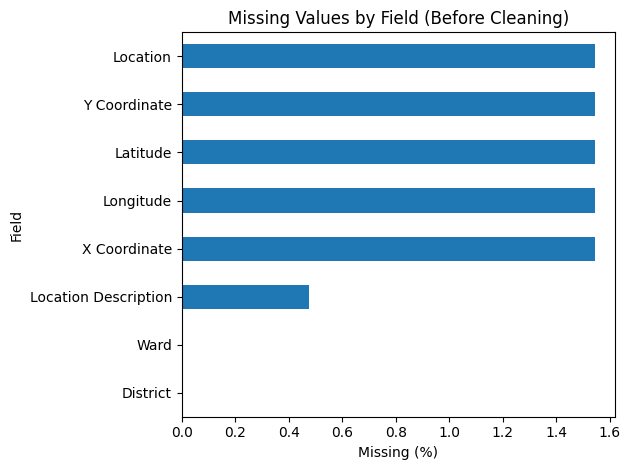

Rows (2017) before cleaning: 267562


In [2]:
# =============================
# 1) Missingness before cleaning (Figure 25)
# =============================
def miss_pct(df, col):
    return (df.select(F.sum(F.when(
                F.col(col).isNull() | F.isnan(col) | (F.col(col) == ""), 1
            ).otherwise(0)).alias("m"),
            F.count(F.lit(1)).alias("n"))
            .withColumn("pct", F.col("m")/F.col("n")*100)).collect()[0]["pct"]

fields = []
for c in [COL_X, COL_Y, COL_LAT, COL_LON, COL_LOC, COL_LOCDESC, "District", "Ward"]:
    if c and c in df2017.columns:
        fields.append(c)

rows_before = df2017.count()
records = []
for c in fields:
    records.append({"Field": c, "Missing(%)": miss_pct(df2017, c)})
miss_before = pd.DataFrame(records).sort_values("Missing(%)", ascending=True)

ax = miss_before.plot(kind="barh", x="Field", y="Missing(%)", legend=False)
ax.set_title("Missing Values by Field (Before Cleaning)")
ax.set_xlabel("Missing (%)")
ax.set_ylabel("Field")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure25_missing_before.png")
plt.show()

miss_before.to_csv(f"{CSV_DIR}/fig25_missing_before.csv", index=False)
print("Rows (2017) before cleaning:", rows_before)


In [3]:
# =============================
# 2) Cleaning steps (drop NA lat/lon; conservative IQR clip on longitude)
# =============================
df_clean = df2017

# Drop missing coordinates (Latitude or Longitude)
df_clean = df_clean.filter(F.col(COL_LAT).isNotNull() & F.col(COL_LON).isNotNull())

rows_after_dropna = df_clean.count()

# IQR for Longitude (on NA-dropped sample)
q1, q3 = df_clean.approxQuantile(COL_LON, [0.25, 0.75], 0.001)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr

outliers = df_clean.filter((F.col(COL_LON) < lower) | (F.col(COL_LON) > upper)).count()
df_clipped = df_clean.filter((F.col(COL_LON) >= lower) & (F.col(COL_LON) <= upper))
rows_after_clip = df_clipped.count()

print(f"Rows after dropping LAT/LON nulls: {rows_after_dropna}")
print(f"Potential longitude IQR outliers: {outliers}")
print(f"Rows after longitude clipping: {rows_after_clip}")

# Save counts
pd.DataFrame({
    "stage": ["before", "after_dropna", "after_clip"],
    "rows": [rows_before, rows_after_dropna, rows_after_clip],
    "lon_q1": [q1, q1, q1],
    "lon_q3": [q3, q3, q3],
    "lon_lower": [lower, lower, lower],
    "lon_upper": [upper, upper, upper],
}).to_csv(f"{CSV_DIR}/fig28_row_counts.csv", index=False)


Rows after dropping LAT/LON nulls: 263432
Potential longitude IQR outliers: 1499
Rows after longitude clipping: 261933


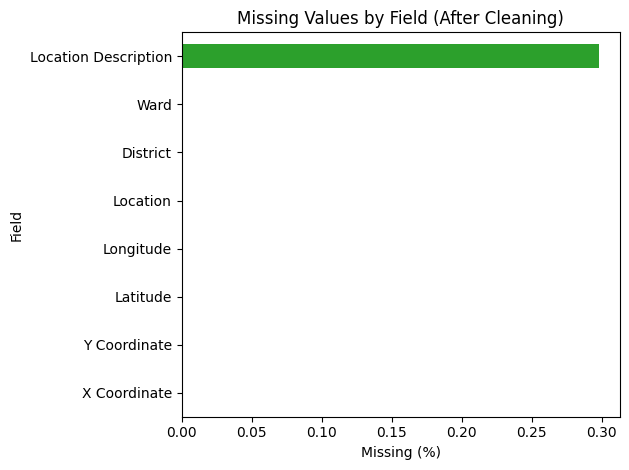

In [4]:
# =============================
# 3) Missingness after cleaning (Figure 26)
# =============================
records = []
for c in fields:
    if c and c in df_clipped.columns:
        records.append({"Field": c, "Missing(%)": miss_pct(df_clipped, c)})
miss_after = pd.DataFrame(records).sort_values("Missing(%)", ascending=True)

ax = miss_after.plot(kind="barh", x="Field", y="Missing(%)", legend=False, color="tab:green")
ax.set_title("Missing Values by Field (After Cleaning)")
ax.set_xlabel("Missing (%)")
ax.set_ylabel("Field")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure26_missing_after.png")
plt.show()

miss_after.to_csv(f"{CSV_DIR}/fig26_missing_after.csv", index=False)


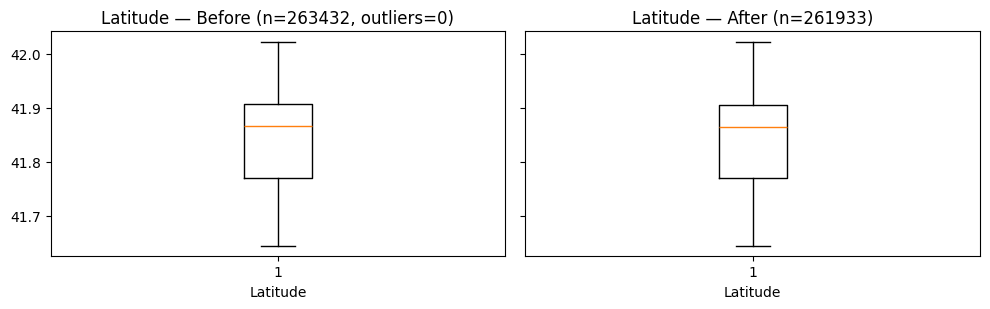

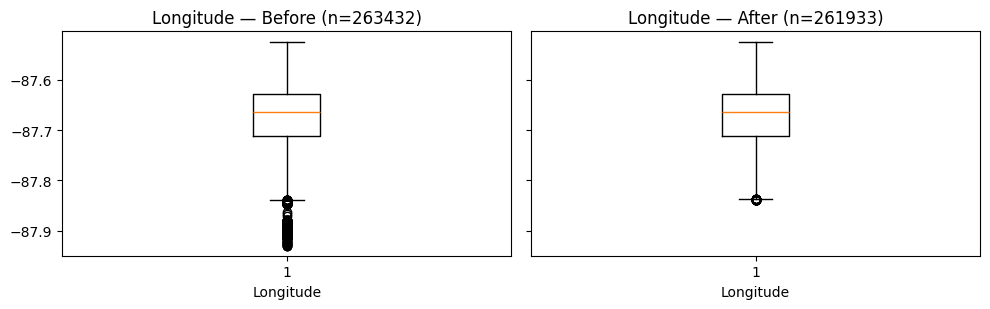

In [5]:
# =============================
# 4) Boxplots Before/After (Latitude & Longitude) — Figures 27/28
# =============================
def to_pd_col(df, col):
    return df.select(F.col(col).alias(col)).dropna().toPandas()[col]

lat_before = to_pd_col(df_clean, COL_LAT)
lat_after  = to_pd_col(df_clipped, COL_LAT)
lon_before = to_pd_col(df_clean, COL_LON)
lon_after  = to_pd_col(df_clipped, COL_LON)

# Latitude boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3.2), sharey=True)
axes[0].boxplot(lat_before, vert=True)
axes[0].set_title(f"Latitude — Before (n={len(lat_before)}, outliers=0)")
axes[0].set_xlabel("Latitude")
axes[1].boxplot(lat_after, vert=True)
axes[1].set_title(f"Latitude — After (n={len(lat_after)})")
axes[1].set_xlabel("Latitude")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure27_lat_box_before_after.png")
plt.show()

# Longitude boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 3.2), sharey=True)
axes[0].boxplot(lon_before, vert=True)
axes[0].set_title(f"Longitude — Before (n={len(lon_before)})")
axes[0].set_xlabel("Longitude")
axes[1].boxplot(lon_after, vert=True)
axes[1].set_title(f"Longitude — After (n={len(lon_after)})")
axes[1].set_xlabel("Longitude")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/figure28_lon_box_before_after.png")
plt.show()


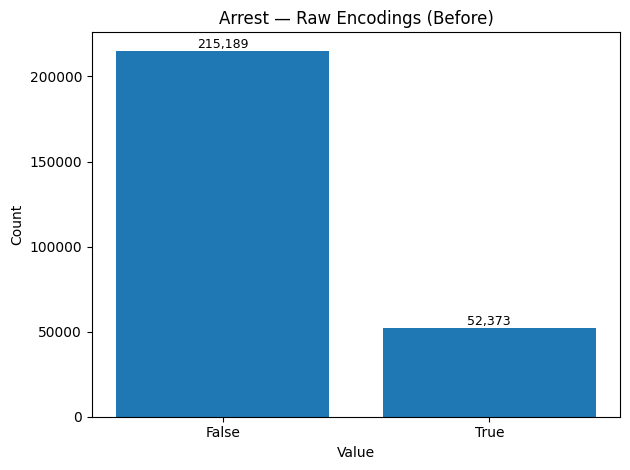

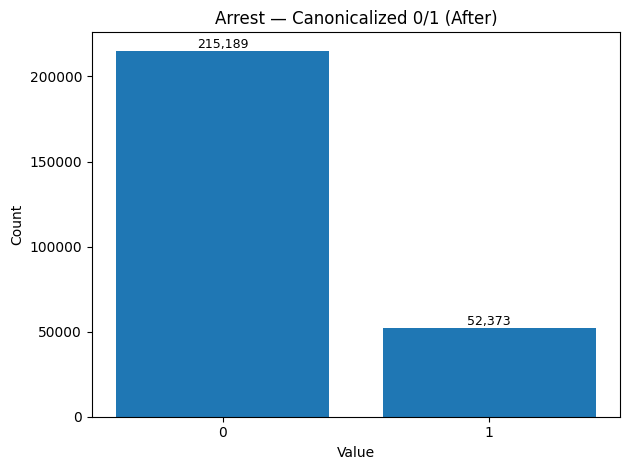

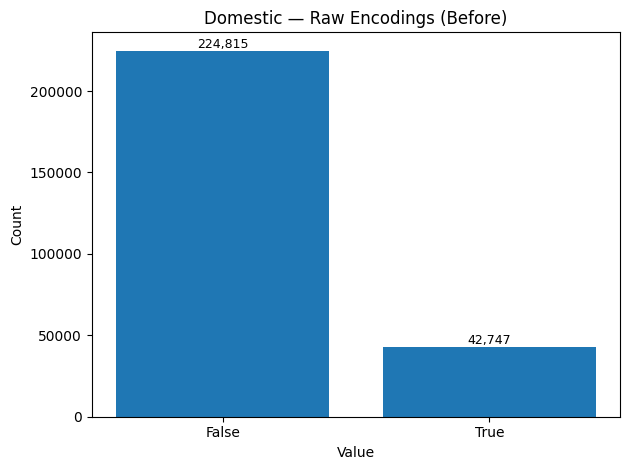

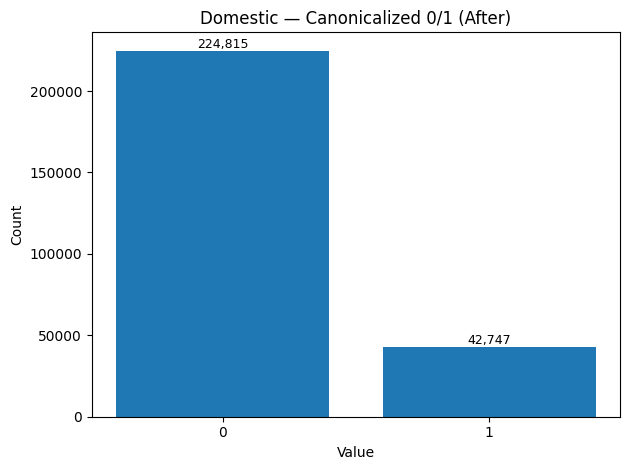

In [6]:
# =============================
# 5) Measurement issues (Arrest & Domestic) — Figures 29–32
# =============================
def label_bar(ax):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{int(h):,}", (p.get_x()+p.get_width()/2, h),
                    ha='center', va='bottom', fontsize=9, rotation=0)

def to_bool(colname):
    return (F.when(F.lower(F.col(colname)) == "true", True)
             .when(F.lower(F.col(colname)) == "false", False)
             .otherwise(F.col(colname).cast(T.BooleanType())))

# Arrest before
if "Arrest" in df2017.columns:
    arrest_before = (df2017.groupBy("Arrest").count().toPandas()
                     .sort_values("count", ascending=False))
    fig, ax = plt.subplots()
    ax.bar(arrest_before["Arrest"].astype(str), arrest_before["count"])
    ax.set_title("Arrest — Raw Encodings (Before)")
    ax.set_xlabel("Value"); ax.set_ylabel("Count")
    label_bar(ax)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/figure29_arrest_before.png")
    plt.show()

# Arrest after (0/1)
if "Arrest" in df2017.columns:
    df_c = df2017.withColumn("Arrest_bool", to_bool("Arrest"))                  .withColumn("Arrest_bin", F.when(F.col("Arrest_bool")==True, 1).otherwise(0))
    arrest_after = (df_c.groupBy("Arrest_bin").count().toPandas()
                    .sort_values("Arrest_bin"))
    fig, ax = plt.subplots()
    ax.bar(arrest_after["Arrest_bin"].astype(str), arrest_after["count"])
    ax.set_title("Arrest — Canonicalized 0/1 (After)")
    ax.set_xlabel("Value"); ax.set_ylabel("Count")
    label_bar(ax)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/figure30_arrest_after.png")
    plt.show()

# Domestic before & after
if "Domestic" in df2017.columns:
    dom_before = (df2017.groupBy("Domestic").count().toPandas()
                  .sort_values("count", ascending=False))
    fig, ax = plt.subplots()
    ax.bar(dom_before["Domestic"].astype(str), dom_before["count"])
    ax.set_title("Domestic — Raw Encodings (Before)")
    ax.set_xlabel("Value"); ax.set_ylabel("Count")
    label_bar(ax)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/figure31_domestic_before.png")
    plt.show()

    df_c2 = df2017.withColumn("Domestic_bool", to_bool("Domestic"))                   .withColumn("Domestic_bin", F.when(F.col("Domestic_bool")==True, 1).otherwise(0))
    dom_after = (df_c2.groupBy("Domestic_bin").count().toPandas()
                 .sort_values("Domestic_bin"))
    fig, ax = plt.subplots()
    ax.bar(dom_after["Domestic_bin"].astype(str), dom_after["count"])
    ax.set_title("Domestic — Canonicalized 0/1 (After)")
    ax.set_xlabel("Value"); ax.set_ylabel("Count")
    label_bar(ax)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/figure32_domestic_after.png")
    plt.show()


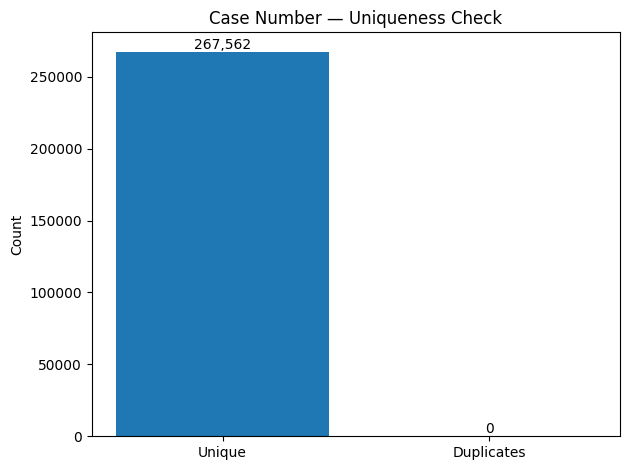

In [7]:
# =============================
# 6) Case Number — Uniqueness Check (Figure 33)
# =============================
if "Case Number" in df2017.columns:
    total = df2017.count()
    nunique = df2017.select("Case Number").distinct().count()
    dup = total - nunique

    # Bar chart
    fig, ax = plt.subplots()
    ax.bar(["Unique", "Duplicates"], [nunique, dup])
    ax.set_title("Case Number — Uniqueness Check")
    ax.set_xlabel("")
    ax.set_ylabel("Count")
    # Annotate bars
    for x, v in zip(["Unique", "Duplicates"], [nunique, dup]):
        ax.annotate(f"{v:,}", (["Unique","Duplicates"].index(x), v),
                    ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"{FIG_DIR}/figure33_case_uniqueness.png")
    plt.show()

    # Save a CSV summary
    import pandas as pd
    pd.DataFrame({"metric": ["total_rows_2017", "unique_case_numbers", "duplicates"],
                  "value": [total, nunique, dup]}).to_csv(
        f"{CSV_DIR}/fig33_case_number_uniqueness.csv", index=False)


In [8]:
# =============================
# 7) Output recap
# =============================
import glob, pprint
print("Saved figures:")
pprint.pp(sorted(glob.glob(FIG_DIR + "/*25*.png") +
                 glob.glob(FIG_DIR + "/*26*.png") +
                 glob.glob(FIG_DIR + "/*27*.png") +
                 glob.glob(FIG_DIR + "/*28*.png") +
                 glob.glob(FIG_DIR + "/*29*.png") +
                 glob.glob(FIG_DIR + "/*30*.png") +
                 glob.glob(FIG_DIR + "/*31*.png") +
                 glob.glob(FIG_DIR + "/*32*.png") +
                 glob.glob(FIG_DIR + "/*33*.png")))

print("\nSaved CSVs:")
pprint.pp(sorted(glob.glob(CSV_DIR + "/*.csv")))


Saved figures:
['/content/drive/MyDrive/Infosys 722/figs/figure25_missing_before.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure26_missing_after.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure27_lat_box_before_after.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure28_lon_box_before_after.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure29_arrest_before.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure30_arrest_after.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure31_domestic_before.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure32_domestic_after.png',
 '/content/drive/MyDrive/Infosys 722/figs/figure33_case_uniqueness.png']

Saved CSVs:
['/content/drive/MyDrive/Infosys 722/CrimeData_2017.csv',
 '/content/drive/MyDrive/Infosys 722/apple_stock_data.csv',
 '/content/drive/MyDrive/Infosys 722/fig17_hour_hist.csv',
 '/content/drive/MyDrive/Infosys 722/fig18_lat_values.csv',
 '/content/drive/MyDrive/Infosys 722/fig19_lon_values.csv',
 '/content/drive/